# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de um RASA bot.

## Instalação

### Configurando jupyter

In [30]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Instalação do Rasa


In [31]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download en_core_web_md;
!{python} -m spacy link --force en_core_web_md en;

Requirement already up-to-date: rasa_core==0.9.0a7 in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.9.0a7)
Requirement already up-to-date: rasa_nlu[spacy] in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.13.7)



    Linking successful
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/en_core_web_md
    -->
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')


    Linking successful
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/en_core_web_md
    -->
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Verificando versões:

In [32]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("en")("Hello world!"))

rasa_nlu: 0.13.7 rasa_core: 0.9.0a7
Loading spaCy language model...
Hello world!


### Ferramentas adicionais

Atualize a instalação de acordo com seu sistema operacional

In [33]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!brew install graphviz;

In [34]:
!{python} -m pip install pygraphviz;

## Adicionando nlu (natural language understanding)

Nesta parte o bot vai aprender a entender a linguagem

In [35]:
nlu_md = """
## intent:greet
- hey I am [Peter](PERSON)
- hello there I am [Hans](PERSON)
- hi I am [Tom](PERSON)
- hello there
- good morning
- good evening
- moin
- hey there
- let's go
- hey dude
- goodmorning
- goodevening
- good afternoon

## intent:goodbye
- cu
- good by
- cee you later
- good night
- good afternoon
- bye
- goodbye
- have a nice day
- see you around
- bye bye
- see you later

## intent:mood_affirm
- yes
- indeed
- of course
- that sounds good
- correct

## intent:mood_deny
- no
- never
- I don't think so
- don't like that
- no way
- not really

## intent:mood_great
- perfect
- very good
- great
- amazing
- feeling like a king
- wonderful
- I am feeling very good
- I am great
- I am amazing
- I am going to save the world
- super
- extremely good
- so so perfect
- so good
- so perfect

## intent:mood_unhappy
- my day was horrible
- I am sad
- I don't feel very well
- I am disappointed
- super sad
- I'm so sad
- sad
- very sad
- unhappy
- bad
- very bad
- awful
- terrible
- not so good
- not very good
- extremly sad
- so saad
- so sad
"""

%store nlu_md > nlu.md

Writing 'nlu_md' (str) to file 'nlu.md'.


### NLU Pipeline

Criando um pipeline de nlu para o bot.

`Caso queira testar diferentes algoritmos/modelos dentro do RASA nlu, mude a celula seguinte.`

In [36]:
config = """
language: "en"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


### Treinando o modelo do Rasa NLU

In [37]:
from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config

# loading the nlu training samples
training_data = load_data("nlu.md")

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_great', 'greet', 'mood_unhappy', 'mood_affirm', 'goodbye', 'mood_deny'
	- entity examples: 3 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.utils.spacy_utils:Trying to load spacy model with name 'en'
INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.model:Starting to train component nlp_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component tokenizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component ner_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train component intent_featurizer_spacy
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Starting to train componen

Fitting 2 folds for each of 6 candidates, totalling 12 fits


### Avaliação do modelo de NLU treinado

`Caso queira testar mensagens específicas mande a mensagem na célula seguinte`

In [38]:
pprint(interpreter.parse("doing great"))

{
  "intent": {
    "name": "mood_great",
    "confidence": 0.5942385019366108
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "mood_great",
      "confidence": 0.5942385019366108
    },
    {
      "name": "goodbye",
      "confidence": 0.10839661098383098
    },
    {
      "name": "mood_unhappy",
      "confidence": 0.10281680892300119
    },
    {
      "name": "mood_affirm",
      "confidence": 0.07182652256695544
    },
    {
      "name": "greet",
      "confidence": 0.06998439065278386
    },
    {
      "name": "mood_deny",
      "confidence": 0.052737164936817474
    }
  ],
  "text": "doing great"
}


### Avaliação de correlação das intents

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.
INFO:rasa_nlu.training_data.loading:Training data format of nlu.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 68 (6 distinct intents)
	- Found intents: 'mood_great', 'greet', 'mood_unhappy', 'mood_affirm', 'goodbye', 'mood_deny'
	- entity examples: 3 (1 distinct entities)
	- found entities: 'PERSON'

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 68 examples that have a defined intent out of 68 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9852163087457204
INFO:rasa_nlu.evaluate:Precision: 0.986344537815126
INFO:rasa_nlu.evaluate:Accuracy:  0.9852941176470589
INFO:rasa_nlu.evaluate:Classification report: 
              precision    recall  f1-score   support

     goodbye       1.00      0.91      0.95        11
       greet       0.93      1.00      0.96        13
 mood_affirm       1.00    

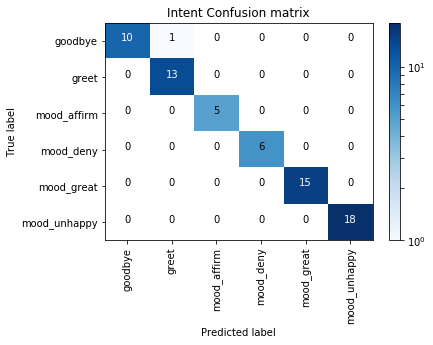

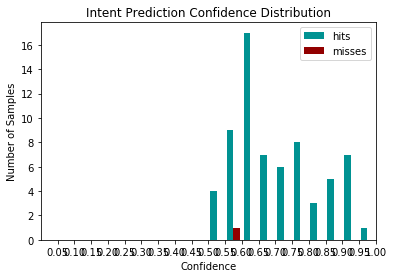

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  0.970857463104801
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  0.9433962264150944
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

       DATE       0.00      0.00      0.00         0
     PERSON       1.00      1.00      1.00         3
       TIME       0.00      0.00      0.00         0
  no_entity       1.00      0.94      0.97       156

avg / total       1.00      0.94      0.97       159



In [39]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("nlu.md", model_directory)

# RASA core

`Adicionando stories`

In [40]:
stories_md = """
## happy path               <!-- name of the story - just for debugging -->
* greet              
  - utter_greet
* mood_great               <!-- user utterance, in format intent[entities] -->
  - utter_happy
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_goodbye
  
## sad path 1               <!-- this is already the start of the next story -->
* greet
  - utter_greet             <!-- action the bot should execute -->
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_affirm
  - utter_happy

## sad path 2
* greet
  - utter_greet
* mood_unhappy
  - action_retrieve_image
  - utter_cheer_up
  - utter_did_that_help
* mood_deny
  - utter_goodbye
  
## strange user
* mood_affirm
  - utter_happy
* mood_affirm
  - utter_unclear

## say goodbye
* goodbye
  - utter_goodbye

## fallback
- utter_unclear

"""

%store stories_md > stories.md

Writing 'stories_md' (str) to file 'stories.md'.


### Definindo Contexto (domain)

In [41]:
domain_yml = """
intents:
- greet
- goodbye
- mood_affirm
- mood_deny
- mood_great
- mood_unhappy

slots:
  img_api_response:
    type: unfeaturized

actions:
- utter_greet
- utter_cheer_up
- utter_did_that_help
- utter_happy
- utter_goodbye
- utter_unclear
- __main__.ApiAction

templates:
  utter_greet:
  - text: "Hey! How are you?"

  utter_cheer_up:
  - text: "Here is something to cheer you up"

  utter_did_that_help:
  - text: "Did that help you?"

  utter_unclear:
  - text: "I am not sure what you are aiming for."
  
  utter_happy:
  - text: "Great carry on!"

  utter_goodbye:
  - text: "Bye"
"""

%store domain_yml > domain.yml

Writing 'domain_yml' (str) to file 'domain.yml'.


### Visualização do fluxo de conversa

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 188.34it/s, # trackers=1]


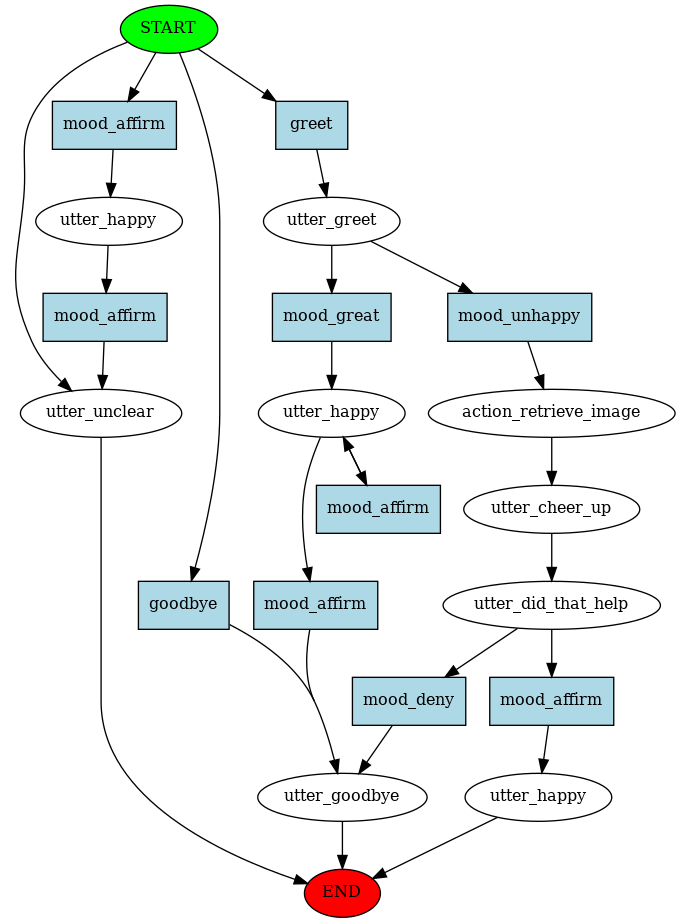

In [42]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

### Treinando o modelo de diálogo

`Para verificar possíveis melhorias no comportamento do bot mude a célula a seguir`

**importante** após identifcar melhorias atualize o arquivo de treinho do bot `train.py`

In [43]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 140.95it/s, # trackers=20]
Processed actions: 171it [00:00, 669.21it/s, # examples=171]
INFO:rasa_core.policies.memoization:Memorized 171 unique action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 171 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 5, 15)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 297       
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0         
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
171/171 [==============================] - 1s 5ms/step - loss: 2.1807 - acc: 0.1053
Epoch 2/400
171/171 [==============================] - 0s 159us/step - loss: 2.0990 - acc: 0.4152
Epoch 3/400
171/171 [==============================] - 0s 161us/step - loss: 2

171/171 [==============================] - 0s 194us/step - loss: 0.4019 - acc: 0.9532
Epoch 76/400
171/171 [==============================] - 0s 206us/step - loss: 0.4364 - acc: 0.9064
Epoch 77/400
171/171 [==============================] - 0s 218us/step - loss: 0.3734 - acc: 0.9415
Epoch 78/400
171/171 [==============================] - 0s 221us/step - loss: 0.4145 - acc: 0.9064
Epoch 79/400
171/171 [==============================] - 0s 227us/step - loss: 0.3846 - acc: 0.9298
Epoch 80/400
171/171 [==============================] - 0s 144us/step - loss: 0.3762 - acc: 0.9357
Epoch 81/400
171/171 [==============================] - 0s 124us/step - loss: 0.3827 - acc: 0.9357
Epoch 82/400
171/171 [==============================] - 0s 189us/step - loss: 0.3653 - acc: 0.9298
Epoch 83/400
171/171 [==============================] - 0s 227us/step - loss: 0.3410 - acc: 0.9474
Epoch 84/400
171/171 [==============================] - 0s 184us/step - loss: 0.3399 - acc: 0.9415
Epoch 85/400
171/171 [=

171/171 [==============================] - 0s 254us/step - loss: 0.1108 - acc: 0.9883
Epoch 158/400
171/171 [==============================] - 0s 255us/step - loss: 0.1297 - acc: 0.9708
Epoch 159/400
171/171 [==============================] - 0s 218us/step - loss: 0.0924 - acc: 0.9883
Epoch 160/400
171/171 [==============================] - 0s 293us/step - loss: 0.0770 - acc: 1.0000
Epoch 161/400
171/171 [==============================] - 0s 213us/step - loss: 0.1237 - acc: 0.9766
Epoch 162/400
171/171 [==============================] - 0s 215us/step - loss: 0.1019 - acc: 0.9825
Epoch 163/400
171/171 [==============================] - 0s 251us/step - loss: 0.1235 - acc: 0.9591
Epoch 164/400
171/171 [==============================] - 0s 226us/step - loss: 0.1121 - acc: 0.9825
Epoch 165/400
171/171 [==============================] - 0s 243us/step - loss: 0.0915 - acc: 0.9883
Epoch 166/400
171/171 [==============================] - 0s 221us/step - loss: 0.0906 - acc: 0.9766
Epoch 167/400


171/171 [==============================] - 0s 198us/step - loss: 0.0458 - acc: 0.9942
Epoch 240/400
171/171 [==============================] - 0s 226us/step - loss: 0.0231 - acc: 1.0000
Epoch 241/400
171/171 [==============================] - 0s 134us/step - loss: 0.0487 - acc: 0.9883
Epoch 242/400
171/171 [==============================] - 0s 136us/step - loss: 0.0505 - acc: 0.9883
Epoch 243/400
171/171 [==============================] - 0s 321us/step - loss: 0.0355 - acc: 1.0000
Epoch 244/400
171/171 [==============================] - 0s 393us/step - loss: 0.0908 - acc: 0.9708
Epoch 245/400
171/171 [==============================] - 0s 194us/step - loss: 0.0736 - acc: 0.9883
Epoch 246/400
171/171 [==============================] - 0s 158us/step - loss: 0.0634 - acc: 0.9825
Epoch 247/400
171/171 [==============================] - 0s 189us/step - loss: 0.0524 - acc: 0.9942
Epoch 248/400
171/171 [==============================] - 0s 231us/step - loss: 0.0315 - acc: 1.0000
Epoch 249/400


171/171 [==============================] - 0s 218us/step - loss: 0.0537 - acc: 0.9825
Epoch 322/400
171/171 [==============================] - 0s 119us/step - loss: 0.0162 - acc: 1.0000
Epoch 323/400
171/171 [==============================] - 0s 160us/step - loss: 0.0307 - acc: 0.9942
Epoch 324/400
171/171 [==============================] - 0s 143us/step - loss: 0.0359 - acc: 0.9942
Epoch 325/400
171/171 [==============================] - 0s 122us/step - loss: 0.0289 - acc: 0.9942
Epoch 326/400
171/171 [==============================] - 0s 114us/step - loss: 0.0267 - acc: 1.0000
Epoch 327/400
171/171 [==============================] - 0s 119us/step - loss: 0.0352 - acc: 0.9942
Epoch 328/400
171/171 [==============================] - 0s 112us/step - loss: 0.0215 - acc: 1.0000
Epoch 329/400
171/171 [==============================] - 0s 107us/step - loss: 0.0189 - acc: 1.0000
Epoch 330/400
171/171 [==============================] - 0s 120us/step - loss: 0.0253 - acc: 1.0000
Epoch 331/400


INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/models/dialogue'


### Inicializando bot completo (core+nlu)

In [44]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Testando conversação

In [45]:
print("Converse com o bot, diga 'stop' para encerrar teste.")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Converse com o bot, diga 'stop' para encerrar teste.
stop


### Avaliação do modelo de diálogo (`stories`)

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 1871.90it/s]
INFO:rasa_core.evaluate:Evaluating 6 stories
Progress:
100%|██████████| 6/6 [00:00<00:00, 27.54it/s]
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

        action_listen       1.00      1.00      1.00        13
action_retrieve_image       1.00      1.00      1.00         2
       utter_cheer_up       1.00      1.00      1.00         2
  utter_did_that_help       1.00      1.00      1.00         2
        utter_goodbye       1.00      1.00      1.00         3
          utter_greet       1.00      1.00      1.00         3
          utter_happy       1.00      1.00      1.00         4
        utter_unclear       1.00      1.00      1.00         1

          avg / total       1.00      1.00      1.00        30

INFO:rasa_nlu.evaluate:Confusion 

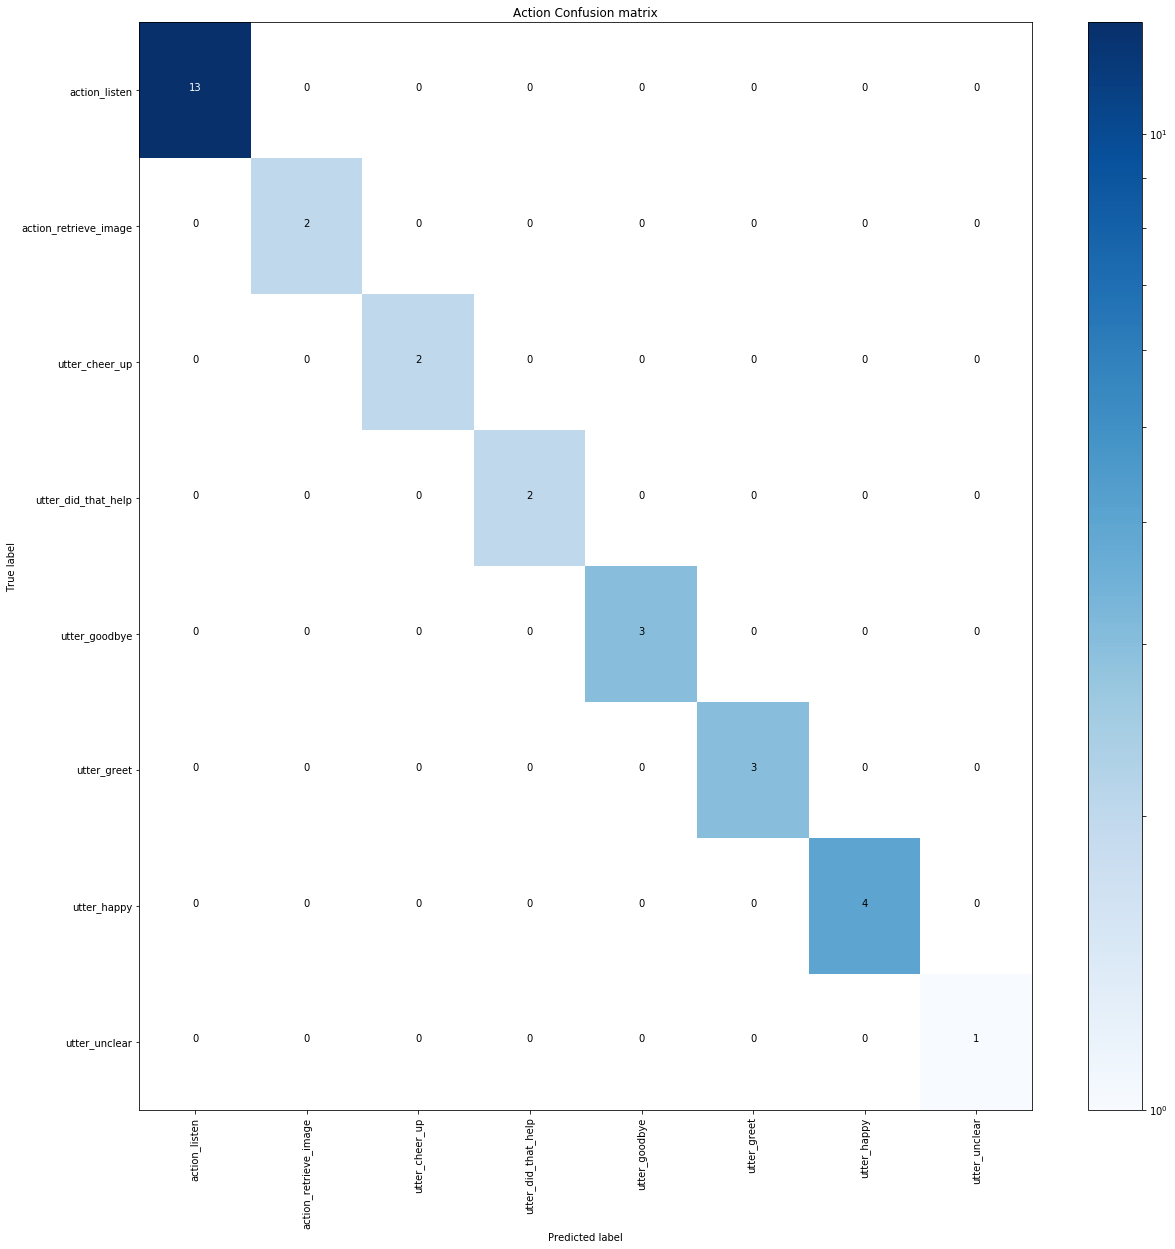

In [46]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")